In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

2022-05-04 09:24:53.548310: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-05-04 09:24:53.548590: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

In [3]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100
max_number = 80
batch_size = 1
max_shift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=3

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [4]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    x_crop_start = int(pos[0] - (cutout_pixel_size-1)/2)
    x_crop_end = int(pos[0] + (cutout_pixel_size-1)/2)
    
    y_crop_start = int(pos[1] - (cutout_pixel_size-1)/2)
    y_crop_end = int(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [5]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

(6, 500, 500)

input_image


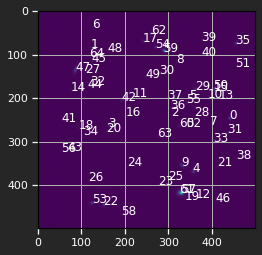

In [6]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == '__main__':


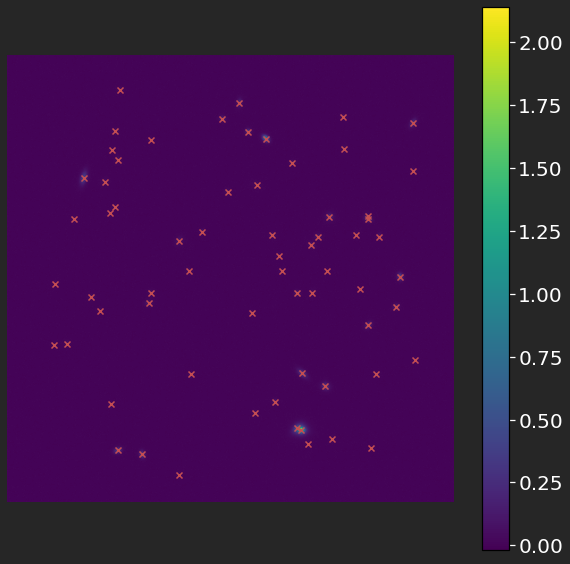

In [7]:
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2]/80000)
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


In [41]:
import sep
sig = []
for i in range(6):
    sig.append(sep.Background(blend['blend_images'][0][i]).globalrms/80000)


In [44]:
sigmabkg[0].globalrms/80000

0.0005127079486846924

In [8]:
blend['blend_list'][0]

IDENT_1,ra,dec,ref_mag,BAND,WEIGHT,GAL_FILENAME,PSF_FILENAME,GAL_HDU,PSF_HDU,PIXEL_SCALE,NOISE_MEAN,NOISE_VARIANCE,NOISE_FILENAME,stamp_flux,IDENT_2,mag_auto,flux_radius,zphot,sersicfit [8],bulgefit [16],fit_status [5],fit_mad_s,fit_mad_b,fit_dvc_btt,use_bulgefit,viable_sersic,hlr [3],flux [4],btk_size,btk_index,x_peak,y_peak,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int32,float64,float64,float64,bytes5,float64,bytes32,bytes36,int32,int32,float64,float64,float64,bytes26,float64,int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,int32,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
98080,37.9688192172392,-0.42350954488460957,22.22100067138672,F814W,0.5986999869346619,real_galaxy_images_25.2_n8.fits,real_galaxy_PSF_images_25.2_n8.fits,554,554,0.029999999329447746,0.00013633500202558935,6.704819952574326e-06,acs_I_unrot_sci_20_cf.fits,33.69639362711632,98080,22.221174240112305,11.323939323425293,0.7106000185012817,0.036328406194353825 .. 1.4723579740876682,0.027463314653697675 .. -3.040445043243198,1 .. 1,0.0029807487663023506,0.0031907707848728532,0.0,0,1,0.2796918479926322 .. 0.0,30.325137570421465 .. 0.0,0.33971817210946575,6980,439.34409823053295,247.38245223979433,0.0,0.0,0.0,0.0,0.0,0.0
263889,-25.767177208871892,-32.963966407217725,24.316999435424805,F814W,0.6323800086975098,real_galaxy_images_25.2_n16.fits,real_galaxy_PSF_images_25.2_n16.fits,756,756,0.029999999329447746,-2.5940200885088416e-06,1.2288700418139342e-05,acs_I_unrot_sci_20_cf.fits,4.250798022287199,263889,24.316686630249023,7.277432918548584,0.19130000472068787,0.013891350834424304 .. -0.2739700018639765,0.009949091099909005 .. -0.5077991390851422,1 .. 1,0.0025161997350890645,0.0024608278963202876,0.2226418677751568,1,1,0.14069623939004317 .. 0.16337354206631538,4.660711523724151 .. 4.58147372257203,0.21832298267655847,14624,120.66411328549373,84.68016527464928,0.0,0.0,0.0,0.0,0.0,0.0
670666,11.447937581110182,-1.6942638305063298,25.013999938964844,F814W,0.6191800236701965,real_galaxy_images_25.2_n21.fits,real_galaxy_PSF_images_25.2_n21.fits,792,792,0.029999999329447746,4.4409200199879706e-05,7.102849849616177e-06,acs_I_unrot_sci_20_cf.fits,1.3731627883535111,670666,25.013652801513672,8.652528762817383,0.7301999926567078,0.002810162937355707 .. -0.2569978888955084,0.001757322025948681 .. -0.08606974000410286,1 .. 1,0.0024905497272970298,0.002351269491995565,0.2683854231103085,1,1,0.21216614171302822 .. 0.2660476628778304,2.329109540480678 .. 2.285064054973663,0.2595758570825488,19299,306.7396879643326,241.02868083397954,0.0,0.0,0.0,0.0,0.0,0.0
99353,-17.761648022146623,3.189553450143414,23.98200035095215,F814W,0.6410199999809265,real_galaxy_images_25.2_n16.fits,real_galaxy_PSF_images_25.2_n16.fits,923,923,0.029999999329447746,8.962339961726684e-06,1.2360200344119221e-05,acs_I_unrot_sci_20_cf.fits,6.5388282815983985,99353,23.98168182373047,6.475813388824463,3.0411999225616455,0.01477154460778752 .. 1.1780696648082154,0.006986193431951589 .. -1.8427637223149513,1 .. 1,0.003287931849323384,0.003281116873839217,0.5354274867971985,1,1,0.15432249738010803 .. 0.18163477564394265,6.847492468387819 .. 6.751356635804512,0.19427439732236262,14781,160.69175966979662,265.4477673110455,0.0,0.0,0.0,0.0,0.0,0.0
56861,21.27458784610107,24.12122383530803,22.10300064086914,F814W,0.5717200040817261,real_galaxy_images_25.2_n71.fits,real_galaxy_PSF_images_25.2_n71.fits,271,271,0.029999999329447746,0.0001535199990030378,6.310269782261457e-06,acs_I_unrot_sci_20_cf.fits,35.75808437881642,56861,22.10323143005371,17.628210067749023,0.3571999967098236,0.01074233623946767 .. 0.5966329733864633,0.009673869001322158 .. 0.6801319161405738,1 .. 1,0.002119342664443944,0.002062213174440027,0.010965478225095974,0,1,0.5065152025027556 .. 0.0,35.041587590175766 .. 0.0,0.5288462902118347,65303,355.8729396077379,370.10612036781504,0.0,0.0,0.0,0.0,0.0,0.0
24217,19.550503116506334,-9.35749821651

In [9]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0]/80000, 
              detected_positions,
              latent_dim=8, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              max_iter=300)

2022-05-04 09:26:11.022475: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-05-04 09:26:11.022691: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 09:26:11.022833: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-05-04 09:26:11.024318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 09:26:11.

In [10]:
#deb.run_debvader()

In [11]:
#fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

#for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [12]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 2])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [13]:
len(blend['blend_list'][0])

65

In [14]:
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.000005*45*45*len(blend['blend_list'][0])*3, min_num_steps=50, window_size=20)
#convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.02, decay_steps=8, decay_rate=0.9, staircase=True)
optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=0.5)

deb(convergence_criterion, optimizer=optimizer)


--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 65
Dimensions of latent space: 8


[0.00174613425 0.0137138292 0.0278138313 0.0214851759 0.014286112 0.00909054745]
[0.00146698311 0.0113544101 0.0230720341 0.0179816503 0.0123234941 0.0084285764]
[0.00116136053 0.00870959088 0.0177988317 0.0141450148 0.0102546643 0.00778905209]
[0.000928984955 0.00661138725 0.0136405351 0.0111892493 0.00875613559 0.0073720119]
[0.000766589423 0.00503318338 0.0105159674 0.00903782621 0.00774380798 0.00711479736]
[0.000660169113 0.00389388623 0.00826780125 0.0075616152 0.00710774865 0.00696114032]
[0.000598767481 0.00314551149 0.0068112365 0.00665631751 0.00675084861 0.00687646121]
[0.000565114082 0.00268252729 0.00591768837 0.00611912506 0.00655251276 0.00683262]
[0.000549122 0.00244962052 0.00546129141 0.00586067699 0.0064599379 0.00680962345]
[0.000542041 0.00234162761 0.00525403814 0.00574263278 0.00641645165 0.00679990184]
[0.000537311658 0.00226267404 0.00510535203 0.00566225685 0.00639069406 0.00679254904]
[0.000534077466 0.0022076976 0.00500188675 0.00560802547 0.00636829762 0.00

--- Gradient descent complete ---

Time taken for gradient descent: 148.94641828536987


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


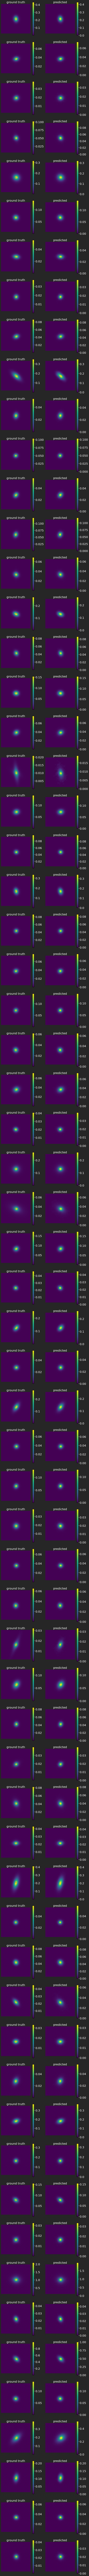

In [15]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9))
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 0].set_title("ground truth", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')


    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=20)
    ax[i, 1].set_title("predicted", fontsize=20)
    ax[i, 1].axis('off')

    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
#     plt.axis('off')

plt.savefig("MAP_predictions")
plt.show()

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


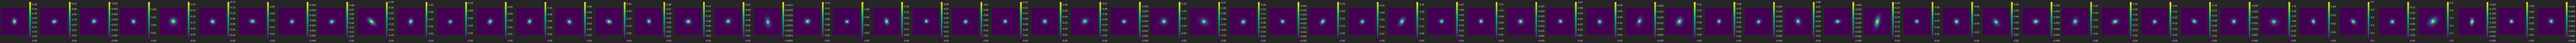

In [16]:
fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]

    im2 = ax[i].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i])
    cbar.ax.tick_params(labelsize=15)
    ax[i].axis("off")
    #ax[i].set_title("predicted")
plt.savefig("predictions")

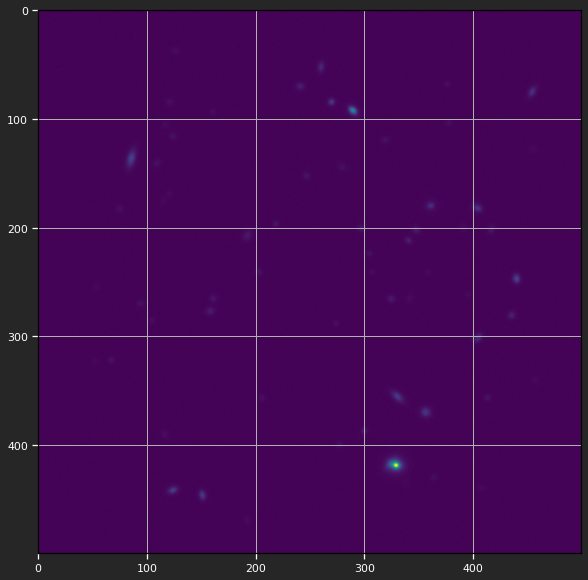

In [17]:
fig = plt.figure(figsize=(10,10))
plt.imshow(blend['blend_images'][0][1])

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == '__main__':


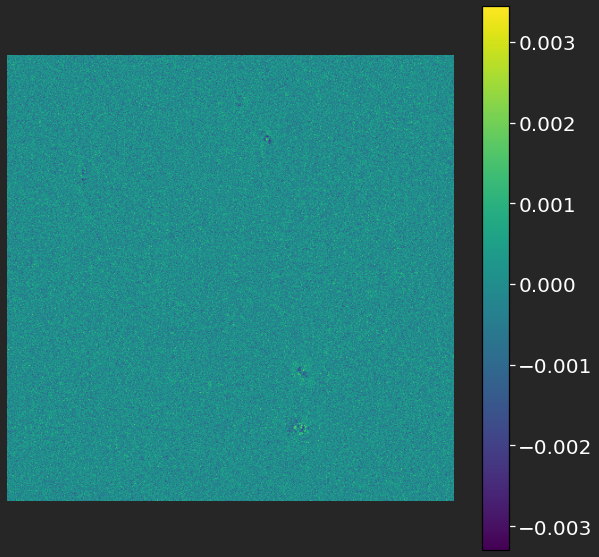

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(blend['blend_images'][0]/80000, use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 0])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

tf.Tensor(
[749271.4  751900.1  753153.7  754430.44 754013.7  753810.7  754050.56
 754336.6  754878.3  754727.2  754099.8  753415.4  752745.6  752270.1
 752022.06 751740.   751579.25 751484.1  751334.2  751186.56 751090.8
 750994.4  750987.25 750885.2  750915.3  750804.25 750795.8  750657.94
 750729.1  750625.56 750590.56 750575.   750553.   750430.06 750460.7
 750369.75 750370.6  750328.75 750350.8  750347.4  750302.6  750350.25
 750246.1  750262.25 750279.44 750194.7  750243.25 750226.44 750202.4
 750229.25 750263.06 750149.56 750248.6  750220.1  750245.06 750144.25
 750128.   750142.56 750131.9  750123.94 750150.06 750106.1  750077.5
 750093.25 750096.94 750094.   750082.5  750052.   750039.1  750050.
 750058.   750011.44 750047.56 750017.1  750029.25 750001.5  749997.6
 749966.75 749983.06 749997.3  750006.9  749957.3  749931.2  749913.44
 749920.56 749956.56 749939.   749888.6  749884.5  749884.9  749895.94
 749861.1  749866.3  749878.7  749866.6  749905.94 749831.   749838.75
 74

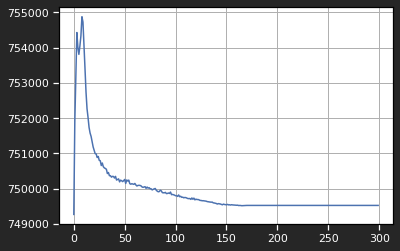

In [19]:
print(deb.results)
plt.plot(deb.results)

In [20]:
from scripts.metrics import compute_reconstruction_metrics
from scripts.extraction import extract_cutouts

In [21]:
field_size = np.shape(blend['isolated_images'][0][i])[1]

In [22]:
field_image=blend['blend_images'][0]

In [23]:
np.amax(field_image[5])

41426.31681829051

In [24]:
cutouts, list_idx = extract_cutouts(field_image=blend['blend_images'][0]/80000, galaxy_distances_to_center=np.array(detected_positions)-int(field_size/2), cutout_size=45, channel_last=False)

In [25]:
np.shape(cutouts)

(65, 45, 45, 6)

In [26]:
np.shape(deb.components)

(65, 45, 45, 6)

In [27]:
results=compute_reconstruction_metrics(deb.components, cutouts)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


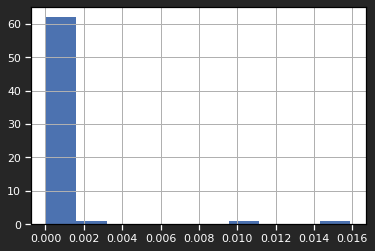

In [35]:
plt.hist(results["mse"]);

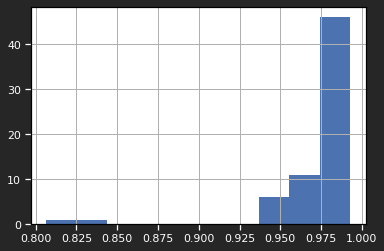

In [34]:
plt.hist(results["ssim"]);

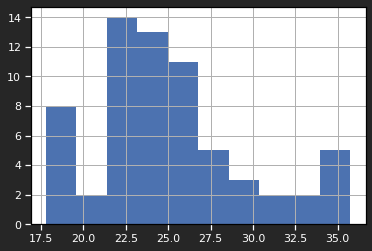

In [33]:
plt.hist(results['psnr']);